# N-gram Extraction in Python using NLTK

In [ ]:
!pip install pandas matplotlib nltk PySastrawi --upgrade

- pandas: For reading and manipulating CSV data. It provides the DataFrame structure which makes it easy to preprocess and analyze text data.
- matplotlib: For plotting the frequencies of n-grams (bigrams and trigrams) as bar charts.
- nltk (Natural Language Toolkit): Includes several utilities such as the ngrams function to generate n-grams and the corpus of stopwords to filter out common words.
- re (Regular Expressions): Used to perform various text preprocessing tasks such as cleaning punctuation, handling number formats, and removing unwanted patterns.
- Sastrawi: A library developed for Indonesian language processing that provides a stemmer to reduce words to their base form (root words). This is crucial for handling text in Indonesian as it reduces variations of words to a standard form.

### Installing Libraries

In [ ]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
from nltk import ngrams
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

df = pd.read_csv("data/news-watch-ketegangan perdagangan-sd-2024-01.csv")
df = df.drop_duplicates(subset=["keyword", "source", "link"])

df["content"] = df["content"].fillna("")

### Preprocessing Text

The function preprocess_text(text) performs multiple steps to prepare the text for n-gram extraction:

- Case Folding: Converts all text into lowercase to ensure consistency.
- Number Normalization: Uses a regex to combine numbers with thousand separators (e.g., "1,000" or "1.000") into a single numeric string, removing extra characters.
- Punctuation Removal: Removes punctuation that might interfere with tokenizing words. The regex carefully avoids removing punctuation part of numeric values.
- Whitespace Normalization: Collapses multiple spaces into a single space.
- Removing Unwanted Phrases: Uses a list of phrases (such as "advertisement" or "scroll to continue with content") that are deemed unnecessary for analysis. These phrases are removed using case-insensitive regex matching.
- Date Removal: Removes date patterns specific to Indonesian date representations (days like “senin” or months like “januari”) with separate regex patterns.
- Tokenization: Splits the cleaned text on whitespace.
- Stopword Removal: Filters out common Indonesian stopwords using the nltk stopwords list.
- Stemming: Applies the Sastrawi stemmer to reduce each token to its root form, which is useful for grouping different forms of the same word together.

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words("indonesian"))

def preprocess_text(text):
    # Case folding: convert text to lowercase
    text = text.lower()

    # Combine numbers with thousand separators
    text = re.sub(
        r"\b(\d{1,3}(?:[.,]\d{3})+)\b",
        lambda m: m.group(0).replace(".", "").replace(",", ""),
        text,
    )

    # Remove punctuation using regex .,?!:;
    # This pattern matches punctuation that is not part of a number
    text = re.sub(r"(?<!\d)[^\w\s]|[^\w\s](?!\d)", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)

    # Remove the specified unwanted phrases
    unwanted_phrases = [
        "advertisement",
        "scroll to continue with content",
        "cnbc indonesia",
        "kontan co id",
        "jakarta",
        "ihsg",
        "indeks harga saham gabungan",
        "year on year",
        # add more here
    ]
    for phrase in unwanted_phrases:
        # Use regex for case-insensitive replacement and to handle extra spaces
        pattern = re.compile(re.escape(phrase), re.IGNORECASE)
        text = pattern.sub("", text)

    # Remove date patterns
    date_patterns = [
        # Matches "selasa 5 11 2024", "senin 4 11", "5 11 2024", "5 11"
        r"\b(?:(?:senin|selasa|rabu|kamis|jumat|sabtu|minggu)\s+)?\d{1,2}\s+\d{1,2}(?:\s+\d{2,4})?\b",
        # Matches "januari 2024", "september 2024"
        r"\b(?:januari|februari|maret|april|mei|juni|juli|agustus|september|oktober|november|desember)\s+\d{4}\b",
    ]
    for pattern in date_patterns:
        text = re.sub(pattern, "", text)

    # Tokenize the text by splitting on whitespace
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

def generate_ngrams(tokens, n):
    # Generate and join n-grams in one step
    ngrams_list = list(ngrams(tokens, n))
    return [" ".join(ngram) for ngram in ngrams_list]


Generating N-grams

The function generate_ngrams(tokens, n) uses nltk’s ngrams to generate a list of n-grams from a list of tokens. An n-gram is a contiguous sequence of n items from a given sample of text. For example:

- Bigrams: n = 2, e.g., "word1 word2"
- Trigrams: n = 3, e.g., "word1 word2 word3"

In [ ]:

# Apply preprocessing and generate bigrams and trigrams
df["tokens"] = df["content"].apply(preprocess_text)
df["bigrams"] = df["tokens"].apply(lambda x: generate_ngrams(x, 2))
df["trigrams"] = df["tokens"].apply(lambda x: generate_ngrams(x, 3))

# Flatten lists and count frequencies
bigram_counts = Counter(bigram for sublist in df["bigrams"] for bigram in sublist)
trigram_counts = Counter(trigram for sublist in df["trigrams"] for trigram in sublist)

bigram_df = pd.DataFrame(bigram_counts.items(), columns=["bigram", "count"]).sort_values(by="count", ascending=False)
trigram_df = pd.DataFrame(trigram_counts.items(), columns=["trigram", "count"]).sort_values(by="count", ascending=False)

print("Top 10 Bigrams:")
print(bigram_df.head(10))

print("\nTop 10 Trigrams:")
print(trigram_df.head(10))

<BarContainer object of 10 artists>

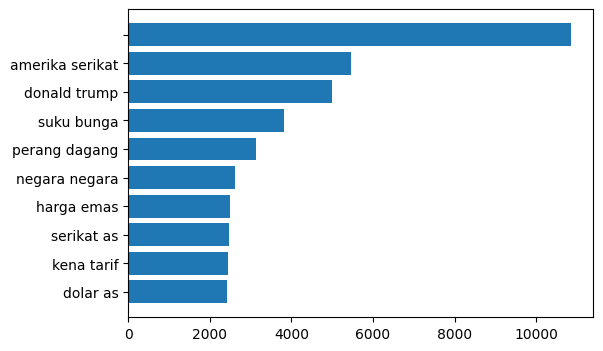

In [ ]:
# Plotting the top 10 bigrams
plt.figure(figsize=(6, 4))
plt.barh(
    bigram_df["bigram"].head(10).iloc[::-1],
    bigram_df["count"].head(10).iloc[::-1],
)

<BarContainer object of 10 artists>

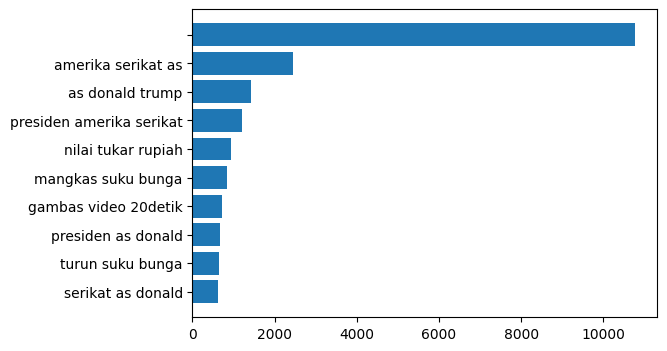

In [ ]:
# Plotting the top 10 trigrams
plt.figure(figsize=(6, 4))
plt.barh(
    trigram_df["trigram"].head(10).iloc[::-1],
    trigram_df["count"].head(10).iloc[::-1],
)

In [ ]:
# Save results
bigram_df.to_csv("output/bigrams.csv", index=False)
trigram_df.to_csv("output/trigrams.csv", index=False)